# Convolutional Neural Networks

We will now build toward the next big idea in neural networks: convolutional neural networks (frequently called CNNs or ConvNets). These are nets that take some inspiration from the way neurons are connected in an animal's visual cortex, where different groups of neurons respond to specific portions of the visual field and then those signals are combined in a sort of hierarchy that is thought to allow animals to extract increasingly complex features within the incoming visual stimuli.

CNNs are are feedforward neural networks like we have seen, but neurons in one layer are not necessarily connected to every neuron in the next layer. Such a more complex architecture, in some sense, allows a regularized version of fully-connected nets in that, they can generalize better to test data and to the real world. Recall, we could learn the whole training set for CIFAR-10 but had at least a 30% less accuracy on test data. Another benefit is that this more sparse sort of structure means we can build deeper or wider neural nets without growing the computation as much as fully-connected nets.

CNNs are some of the best algorithms for image and video recognition problems, but have also been used effectively in anomaly detection, time series analysis in financial markets, and predicting the interactions between proteins and molecules in drug discovery among other applications.

(Please see the class notes for introductory material. We continue with implementing some CNNs.)

## GPU Computing

CNNs especially benefit from parallelization within GPUs. Only NVidia video cards are currently compatible, which can be in your local device or in a cloud. The following code can check if tensorflow sees a GPU

In [84]:
from tensorflow.python.client import device_lib

numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print("Num GPUs Available: ", numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)

#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Num GPUs Available:  1
/device:GPU:0
device: 0, name: GeForce RTX 2070, pci bus id: 0000:04:00.0, compute capability: 7.5


If there is a GPU on the device running the notebook, this prints the name of it. Otherwise, it prints that there are no GPUs available. (Note that, for TensorFlow to see and use a GPU in your local device, you must install NVidia's CUDA parallel computing platform and some drivers.)

TensorFlow, on which Keras is built, automatically exploits GPU resources quite efficiently, so it's not something that requires extra effort on our side. This means we have several layers of abstraction: Keras makes calls to TensorFlow, which makes calls to CUDA, which runs on C/C++. So, it is unrealistic to expect the whole path makes *everything* run optimally with absolute maximum efficiency, but, in practice, it is pretty close! However, I did want to point out that it can be worthwhile to customize lower-level code with TensorFlow or manage parallelization with raw CUDA code. None of this is particularly difficult, and CUDA customization is usually unnecessary, but it can be done.

## Comparison with Fully-Connected Nets

A big difference between CNNs and the fully-connected nets we have seen is that there are far fewer parameters, which helps avoid overfitting. So, let's import some things from Keras and then create some nets to compare them.

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import MaxPooling2D

In [20]:
# Create a fully-connected net and print a model summary
modelFC = Sequential(name = 'Fully Connected Net with shape [784, 100, 100, 10]')
modelFC.add(InputLayer(input_shape = (784,)))

modelFC.add(Dense(100))
modelFC.add(Activation('relu'))

modelFC.add(Dense(100))
modelFC.add(Activation('relu'))

modelFC.add(Dense(10))
modelFC.add(Activation('softmax'))

print(modelFC.summary())

Model: "Fully Connected Net with shape [784, 100, 100, 10]"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 100)               78500     
_________________________________________________________________
activation_28 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_29 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1010      
_________________________________________________________________
activation_30 (Activation)   (None, 10)                0         
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
____________

In [31]:
# Create a CNN and print a model summary
modelCNN = Sequential(name = 'Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10]')

modelCNN.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNN.add(Activation('relu'))

modelCNN.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNN.add(Activation('relu'))

modelCNN.add(Flatten())

modelCNN.add(Dense(10))
modelCNN.add(Activation('softmax'))

print(modelCNN.summary())

Model: "Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10]"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 5)         50        
_________________________________________________________________
activation_58 (Activation)   (None, 28, 28, 5)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 5)         230       
_________________________________________________________________
activation_59 (Activation)   (None, 28, 28, 5)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 3920)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 10)                39210     
_________________________________________________________________
activati

Now, we have about half as many parameters here for a pretty similar net in terms of learning capacity, but, more importantly, the parameters between two successive convolutional layers is absolutely tiny compared to successive dense layers, so CNNs not only overcome some overfitting issues, but are much more computationally friendly if our nets are deep.

Beyond that, CNNs usually have pooling layers that shrink the data after each convolutional layer, usually by taking the max of every distinct square sub-matrix of data coordinates (although there is average pooling, L2 pooling, and others). Quite common is to use a 2-by-2 block.

In [34]:
# Create a CNN with max pooling and print a model summary
modelCNNp = Sequential(name = 'Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10] and 2x2 max pooling' )

modelCNNp.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNNp.add(Activation('relu'))
modelCNNp.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

modelCNNp.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNNp.add(Activation('relu'))
modelCNNp.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

modelCNNp.add(Flatten())

modelCNNp.add(Dense(10))
modelCNNp.add(Activation('softmax'))

print(modelCNNp.summary())

Model: "Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10] and 2x2 max pooling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 28, 28, 5)         50        
_________________________________________________________________
activation_64 (Activation)   (None, 28, 28, 5)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 5)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 5)         230       
_________________________________________________________________
activation_65 (Activation)   (None, 14, 14, 5)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 5)           0         
______________________________________________________

Here, we see the output from the pooling layers is only a fourth as large, which has no impact on the convolutional layers' parameters, but tremendously shrinks the parameters associated with the dense layer at the end, resulting in a model with only 2740 trainable parameters, about 85% less than without pooling layers.

## Implementing a Tiny CNN

Let's make a small CNN called ShallowNet just to get a sense of how to use Keras to build one and use it on some toy data.

In [3]:
class ShallowNet:
    # create the architecture
    def build(height, width, depth, numFilters, classes):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with numFilters number of 3x3 filters
        model.add(Conv2D(numFilters, (3, 3), padding='same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        
        # add a softmax classifier
        model.add(Flatten())
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

Next, let's try to run it on MNIST

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

[INFO] training network...
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 6s 133us/sample - loss: 0.4835 - accuracy: 0.8692 - val_loss: 0.3031 - val_accuracy: 0.9137
Epoch 2/50
48000/48000 [==============================] - 4s 92us/sample - loss: 0.3132 - accuracy: 0.9097 - val_loss: 0.2816 - val_accuracy: 0.9208
Epoch 3/50
48000/48000 [==============================] - 5s 97us/sample - loss: 0.2905 - accuracy: 0.9164 - val_loss: 0.2676 - val_accuracy: 0.9252
Epoch 4/50
48000/48000 [==============================] - 5s 95us/sample - loss: 0.2691 - accuracy: 0.9225 - val_loss: 0.2499 - val_accuracy: 0.9323
Epoch 5/50
48000/48000 [==============================] - 4s 93us/sample - loss: 0.2443 - accuracy: 0.9311 - val_loss: 0.2206 - val_accuracy: 0.9392
Epoch 6/50
48000/48000 [==============================] - 4s 93us/sample - loss: 0.2156 - accuracy: 0.9395 - val_loss: 0.1972 - val_accuracy: 0.9458
Epoch 7/50
48000/48000 [====

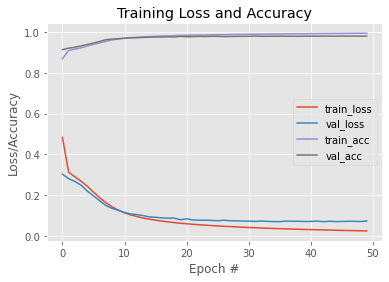

In [5]:
((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = ShallowNet.build(28, 28, 1, 32, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])
print(model.summary())

print("[INFO] training network...")
maxIt = 50
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 32, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Let's try it with the Adam optimizer.

[INFO] training network...
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 5s 105us/sample - loss: 0.2127 - accuracy: 0.9372 - val_loss: 0.0963 - val_accuracy: 0.9743
Epoch 2/20
48000/48000 [==============================] - 5s 96us/sample - loss: 0.0759 - accuracy: 0.9776 - val_loss: 0.0978 - val_accuracy: 0.9729
Epoch 3/20
48000/48000 [==============================] - 5s 95us/sample - loss: 0.0539 - accuracy: 0.9844 - val_loss: 0.0765 - val_accuracy: 0.9786
Epoch 4/20
48000/48000 [==============================] - 5s 99us/sample - loss: 0.0401 - accuracy: 0.9878 - val_loss: 0.0756 - val_accuracy: 0.9792
Epoch 5/20
48000/48000 [==============================] - 5s 97us/sample - loss: 0.0306 - accuracy: 0.9907 - val_loss: 0.0832 - val_accuracy: 0.9769
Epoch 6/20
48000/48000 [==============================] - 5s 96us/sample - loss: 0.0238 - accuracy: 0.9927 - val_loss: 0.0834 - val_accuracy: 0.9789
Epoch 7/20
48000/48000 [====

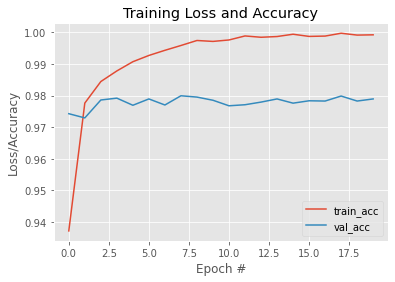

In [7]:
((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = ShallowNet.build(28, 28, 1, 32, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

print("[INFO] training network...")
maxIt = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 32, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
#plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Clearly, even this *tiny* CNN is amazing with MNIST, so let's try it on a harder problem: classifying CIFAR-10

[INFO] training network...
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 3s 71us/sample - loss: 1.5610 - accuracy: 0.4537 - val_loss: 1.3472 - val_accuracy: 0.5328
Epoch 2/20
40000/40000 [==============================] - 2s 50us/sample - loss: 1.2529 - accuracy: 0.5647 - val_loss: 1.2686 - val_accuracy: 0.5655
Epoch 3/20
40000/40000 [==============================] - 2s 49us/sample - loss: 1.1454 - accuracy: 0.6022 - val_loss: 1.2683 - val_accuracy: 0.5574
Epoch 4/20
40000/40000 [==============================] - 2s 50us/sample - loss: 1.0674 - accuracy: 0.6337 - val_loss: 1.2203 - val_accuracy: 0.5794
Epoch 5/20
40000/40000 [==============================] - 2s 48us/sample - loss: 1.0026 - accuracy: 0.6538 - val_loss: 1.2144 - val_accuracy: 0.5794
Epoch 6/20
40000/40000 [==============================] - 2s 48us/sample - loss: 0.9421 - accuracy: 0.6771 - val_loss: 1.1763 - val_accuracy: 0.5967
Epoch 7/20
40000/40000 [=====

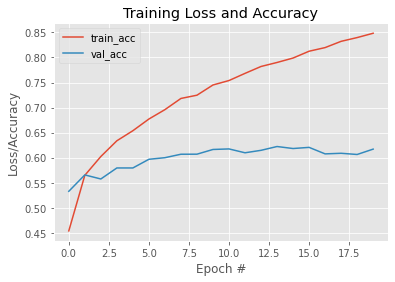

In [13]:
((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = ShallowNet.build(32, 32, 3, 32, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

print("[INFO] training network...")
maxIt = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))
print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
#plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## LeNet

The first CNN that was considered particularly practical is what has become known as LeNet (named after Yann LeCun, who developed it along with his collaborators).

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

class LeNet:
    # create the architecture
    def build(height, width, depth, classes):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with 20 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(32, (5, 5), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer with 50 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(64, (5, 5), padding= 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer
        model.add(Conv2D(128, (5, 5), padding = 'same'))
        model.add(Activation('relu'))
        
        # add a fully-connected layer
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))
        
        # add a softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the constructed model
        return model

### LeNet for Classifying MNIST

Let's run the model on MNIST.

[INFO] training network...
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 4s 88us/sample - loss: 0.1661 - accuracy: 0.9486 - val_loss: 0.0534 - val_accuracy: 0.9851
Epoch 2/100
48000/48000 [==============================] - 3s 71us/sample - loss: 0.0405 - accuracy: 0.9873 - val_loss: 0.0367 - val_accuracy: 0.9900
Epoch 3/100
48000/48000 [==============================] - 3s 70us/sample - loss: 0.0277 - accuracy: 0.9914 - val_loss: 0.0330 - val_accuracy: 0.9901
Epoch 4/100
48000/48000 [==============================] - 3s 71us/sample - loss: 0.0193 - accuracy: 0.9938 - val_loss: 0.0365 - val_accuracy: 0.9898
Epoch 5/100
48000/48000 [==============================] - 3s 70us/sample - loss: 0.0154 - accuracy: 0.9948 - val_loss: 0.0391 - val_accuracy: 0.9902
Epoch 6/100
48000/48000 [==============================] - 3s 70us/sample - loss: 0.0123 - accuracy: 0.9959 - val_loss: 0.0383 - val_accuracy: 0.9918
Epoch 7/100
48000/48000

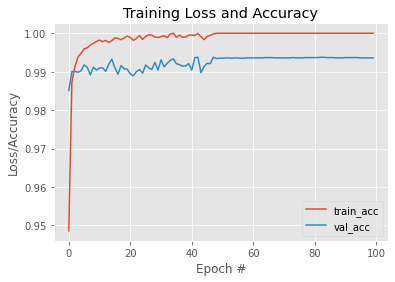

In [26]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNet.build(28, 28, 1, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)
print(model.summary())

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### LeNet for Classifying CIFAR-10

[INFO] training network...
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 4s 109us/sample - loss: 1.5159 - accuracy: 0.4473 - val_loss: 1.3758 - val_accuracy: 0.5215
Epoch 2/20
40000/40000 [==============================] - 3s 82us/sample - loss: 1.0911 - accuracy: 0.6145 - val_loss: 1.0297 - val_accuracy: 0.6404
Epoch 3/20
40000/40000 [==============================] - 3s 81us/sample - loss: 0.8904 - accuracy: 0.6857 - val_loss: 0.8882 - val_accuracy: 0.6886
Epoch 4/20
40000/40000 [==============================] - 3s 81us/sample - loss: 0.7376 - accuracy: 0.7405 - val_loss: 0.8469 - val_accuracy: 0.7064
Epoch 5/20
40000/40000 [==============================] - 3s 82us/sample - loss: 0.6022 - accuracy: 0.7881 - val_loss: 0.8335 - val_accuracy: 0.7147
Epoch 6/20
40000/40000 [==============================] - 3s 81us/sample - loss: 0.4776 - accuracy: 0.8335 - val_loss: 0.8360 - val_accuracy: 0.7209
Epoch 7/20
40000/40000 [====

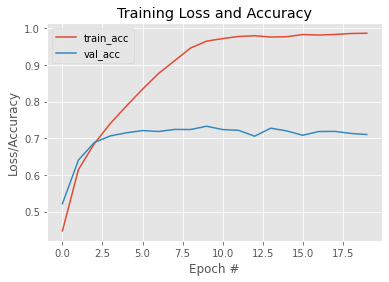

In [16]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNet.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)
print(model.summary())

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
#plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Regularized LeNet

Let's add some regularization to the LeNet and see if it helps the overfitting we see with CIFAR-10.

In [37]:
tf.keras.backend.clear_session()
    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

class LeNetReg:
    # create the architecture
    def build(height, width, depth, classes):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with 20 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(32, (5, 5), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer with 50 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(64, (5, 5), padding= 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer
        model.add(Conv2D(128, (5, 5), padding = 'same'))
        model.add(Activation('relu'))
        
        # add a fully-connected layer
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))
        
        model.add(Dropout(0.5))
        
        # add a softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the constructed model
        return model

Let's run it on MNIST to see if we can improve our (incredible) 99.4% accuracy!

[INFO] training network...
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 4s 83us/sample - loss: 0.1876 - accuracy: 0.9422 - val_loss: 0.0510 - val_accuracy: 0.9850
Epoch 2/100
48000/48000 [==============================] - 3s 70us/sample - loss: 0.0486 - accuracy: 0.9846 - val_loss: 0.0334 - val_accuracy: 0.9900
Epoch 3/100
48000/48000 [==============================] - 3s 70us/sample - loss: 0.0324 - accuracy: 0.9901 - val_loss: 0.0350 - val_accuracy: 0.9903
Epoch 4/100
48000/48000 [==============================] - 3s 69us/sample - loss: 0.0240 - accuracy: 0.9925 - val_loss: 0.0282 - val_accuracy: 0.9915
Epoch 5/100
48000/48000 [==============================] - 3s 68us/sample - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.0357 - val_accuracy: 0.9888
Epoch 6/100
48000/48000 [==============================] - 3s 69us/sample - loss: 0.0166 - accuracy: 0.9948 - val_loss: 0.0307 - val_accuracy: 0.9918
Epoch 7/100
48000/48000

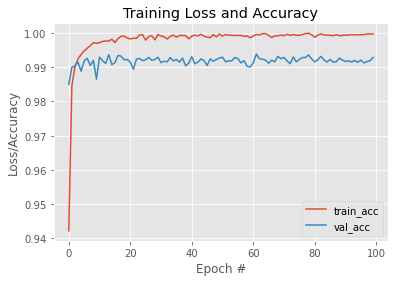

In [39]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(28, 28, 1, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

This is slightly worse, but note the noise in the graphs coming from the extra randomness we added with dropout. This is usually a good thing because it means we were likely searching the parameter space more widely.

Let's try it with CIFAR-10.

[INFO] training network...
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 4s 104us/sample - loss: 1.6007 - accuracy: 0.4123 - val_loss: 1.3152 - val_accuracy: 0.5227
Epoch 2/100
40000/40000 [==============================] - 3s 87us/sample - loss: 1.1786 - accuracy: 0.5763 - val_loss: 1.0506 - val_accuracy: 0.6267
Epoch 3/100
40000/40000 [==============================] - 4s 96us/sample - loss: 0.9651 - accuracy: 0.6595 - val_loss: 0.9044 - val_accuracy: 0.6855
Epoch 4/100
40000/40000 [==============================] - 4s 92us/sample - loss: 0.8299 - accuracy: 0.7086 - val_loss: 0.8487 - val_accuracy: 0.7073
Epoch 5/100
40000/40000 [==============================] - 4s 94us/sample - loss: 0.7099 - accuracy: 0.7525 - val_loss: 0.7912 - val_accuracy: 0.7266
Epoch 6/100
40000/40000 [==============================] - 4s 90us/sample - loss: 0.6049 - accuracy: 0.7873 - val_loss: 0.7900 - val_accuracy: 0.7266
Epoch 7/100
40000/4000

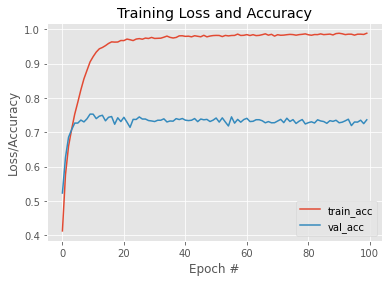

In [51]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Let's go back to SGD and see how it compares.

[INFO] training network...
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 4s 102us/sample - loss: 2.2039 - accuracy: 0.1839 - val_loss: 2.0283 - val_accuracy: 0.2733
Epoch 2/100
40000/40000 [==============================] - 4s 89us/sample - loss: 1.9701 - accuracy: 0.2905 - val_loss: 1.8702 - val_accuracy: 0.3175
Epoch 3/100
40000/40000 [==============================] - 4s 90us/sample - loss: 1.8091 - accuracy: 0.3521 - val_loss: 1.6869 - val_accuracy: 0.4082
Epoch 4/100
40000/40000 [==============================] - 3s 84us/sample - loss: 1.6992 - accuracy: 0.3939 - val_loss: 1.6117 - val_accuracy: 0.4283
Epoch 5/100
40000/40000 [==============================] - 3s 85us/sample - loss: 1.5969 - accuracy: 0.4299 - val_loss: 1.5255 - val_accuracy: 0.4544
Epoch 6/100
40000/40000 [==============================] - 3s 86us/sample - loss: 1.5355 - accuracy: 0.4508 - val_loss: 1.4747 - val_accuracy: 0.4788
Epoch 7/100
40000/4000

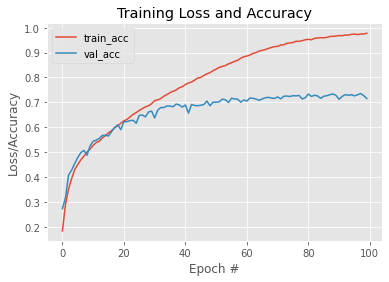

In [81]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We got similar results with SGD.

Some next steps might be to try L1 or L2 regularization.

### Data Augmentation

(this failed badly, more on this another time!)

[INFO] training network...
  ...
    to  
  ['...']
Train for 391 steps
391/391 [==============================] - 23s 59ms/step - loss: 1.6682 - accuracy: 0.3875

 Test accuracy
              precision    recall  f1-score   support

           0       0.62      0.41      0.50      1000
           1       0.56      0.82      0.66      1000
           2       0.44      0.44      0.44      1000
           3       0.48      0.16      0.24      1000
           4       0.44      0.34      0.38      1000
           5       0.53      0.37      0.43      1000
           6       0.46      0.78      0.58      1000
           7       0.57      0.60      0.58      1000
           8       0.59      0.71      0.64      1000
           9       0.53      0.61      0.57      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.50     10000
weighted avg       0.52      0.52      0.50     10000

Model: "sequential"
__________________________________________

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

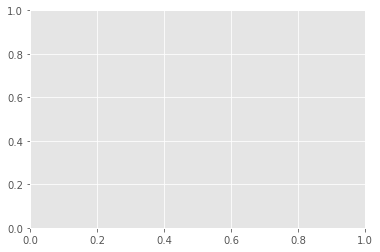

In [83]:
tf.keras.backend.clear_session()

from tensorflow.keras.preprocessing.image import ImageDataGenerator

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1
    )

model = LeNetReg.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
H = model.fit(datagen.flow(trainX, trainY, batch_size = 128), verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()